In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold

sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.2, rc={'lines.markersize': 8})

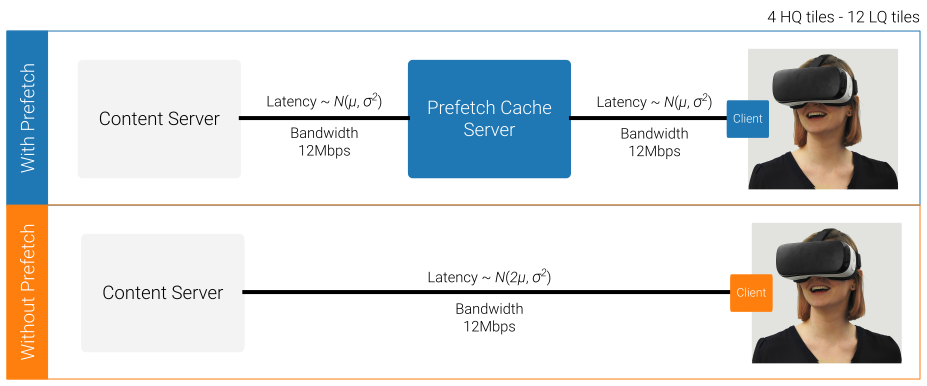

In [8]:
from IPython.display import SVG, display
display(SVG('../Explora-VR-RespTime-Setup.svg'))

In [22]:
K = 4
TYPE = 'pred_model'
LOGS_PATH = '../logs/logs_{l_type}_{variant}/k{K}'.format(l_type=TYPE, variant='{variant}', K=K)
VIDEO_LIST = [0,2,4]
VIDEO_TITLES = ['Sandwich', 'Spotlight', 'Surf']
# K_LIST = [1,3,5,7,9]
USER_LIST = [25, 27, 28, 38, 41, 44]
# QUALITIES = [1, 2, 3, 4, 5]
VARIANTS = {'client_closer': 'NCP', 'halfway': 'HWP', 'server_closer': 'NSP'}
SETUPS = {'pred_model': 'VP predictive model', 'perfect_pred': 'Perfect prediction', 'lq_prefetch': 'Prefetching low quality tiles only'}
PREFETCH_FILE_TMPL = 'log_seg_u{user}_prefetch.txt'
NO_PREFETCH_FILE_TMPL = 'log_seg_u{user}_no_prefetch.txt'
SEG_DUR = 1.065

results_list = []
prefetch_flag = False

for var in VARIANTS:
    for v in VIDEO_LIST:
        for u in USER_LIST:
            for file_tmpl in [PREFETCH_FILE_TMPL, NO_PREFETCH_FILE_TMPL]:
                prefetch_flag = not prefetch_flag
                with open(f'{LOGS_PATH.format(variant=var)}/{v}/{file_tmpl.format(user=u)}', 'r') as p_file:
                    p_times = [float(t.strip()) for t in p_file.readlines()]
                    p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'seg_resp_time'])
                    p_df['seg_resp_time'] = p_times
                    p_df['segment'] = p_df.index + 1
                    p_df['video'] = v
                    p_df['user'] = u
                    p_df['prefetch'] = f'{VARIANTS[var]}' if prefetch_flag else 'NO_PREFETCH'
                    results_list.append(p_df)
                
results_df = pd.concat(results_list, ignore_index=True)

In [23]:
results_df

,video,user,prefetch,seg_resp_time,segment
0,0,25,NCP,0.281841,1
1,0,25,NCP,0.621279,2
2,0,25,NCP,1.027399,3
3,0,25,NCP,1.213760,4
4,0,25,NCP,1.112820,5
...,...,...,...,...,...
3235,4,44,NO_PREFETCH,1.431603,26
3236,4,44,NO_PREFETCH,1.515828,27
3237,4,44,NO_PREFETCH,1.617179,28
3238,4,44,NO_PREFETCH,1.690716,29


In [24]:
stats = pd.DataFrame(group.describe().rename(columns={'seg_resp_time': prefetch}).squeeze()
                         for prefetch, group in results_df[['prefetch', 'seg_resp_time']].groupby(['prefetch'])).T
# stats['change'] = stats.pct_change(axis='columns').iloc[:,-1:] * 100
stats

,HWP,NCP,NO_PREFETCH,NSP
count,540.000000,540.000000,1620.000000,540.000000
mean,1.108200,0.702505,1.497873,1.485761
std,0.309772,0.255400,0.220016,0.290836
min,0.580910,0.278382,1.045972,0.947888
25%,0.899249,0.505880,1.379297,1.313077
50%,1.067247,0.653216,1.519370,1.483286
75%,1.276781,0.854960,1.625776,1.664551
max,2.521749,1.947053,2.272605,2.581463


In [25]:
# k_unique = results_df['k'].unique().tolist()
v_unique = results_df['video'].unique().tolist()

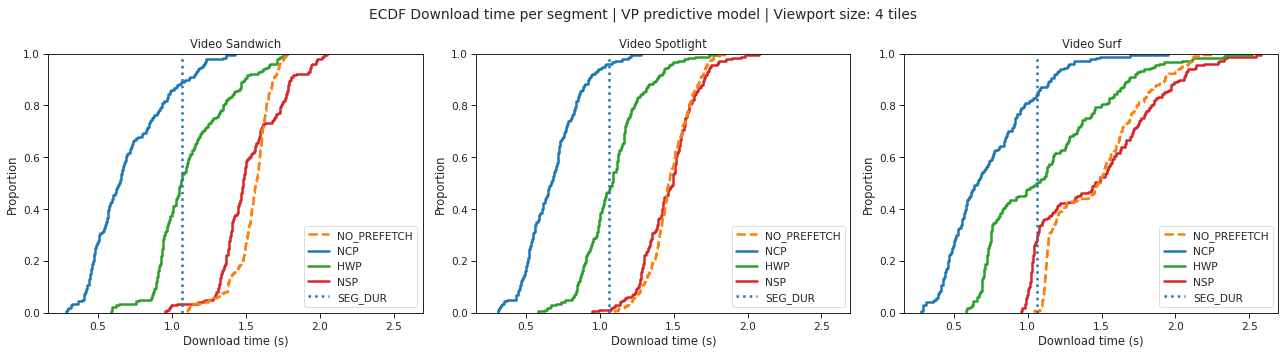

In [26]:
fig, axes = plt.subplots(1, len(v_unique), figsize=(18,5), sharex=True)

for i in range(len(v_unique)):
    axis = axes[i]
    sns.ecdfplot(
        data=results_df[(results_df['video'] == v_unique[i])], 
        x="seg_resp_time", 
        linewidth=2.5, 
        hue="prefetch",
        legend=True,
        ax=axis
    )

    axis.lines[2].set_linestyle("--")
    leg = axis.get_legend()
    leg_texts = [t.get_text() for t in leg.texts]
    leg.get_lines()[leg_texts.index('NO_PREFETCH')].set_linestyle("--")
    axis.set_title(f'Video {VIDEO_TITLES[i]}')
    axis.axvline(x=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
#         axis.set_title(f'Video {j*2}')
    axis.set_xlabel('Download time (s)')
    axis.get_legend().set_title("")
    axis.legend(
        handles=[axis.lines[2], axis.lines[3], axis.lines[1], axis.lines[0], axis.lines[4]], 
        labels=["NO_PREFETCH", f"NCP", f"HWP", f"NSP", "SEG_DUR"]
    )
#     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF Download time per segment | {SETUPS[TYPE]} | Viewport size: {K} tiles')
plt.tight_layout()

In [27]:
fig.savefig(f'ecdf-{TYPE.replace("_", "-")}-k{K}.pdf', format='pdf', dpi=300, bbox_inches='tight')

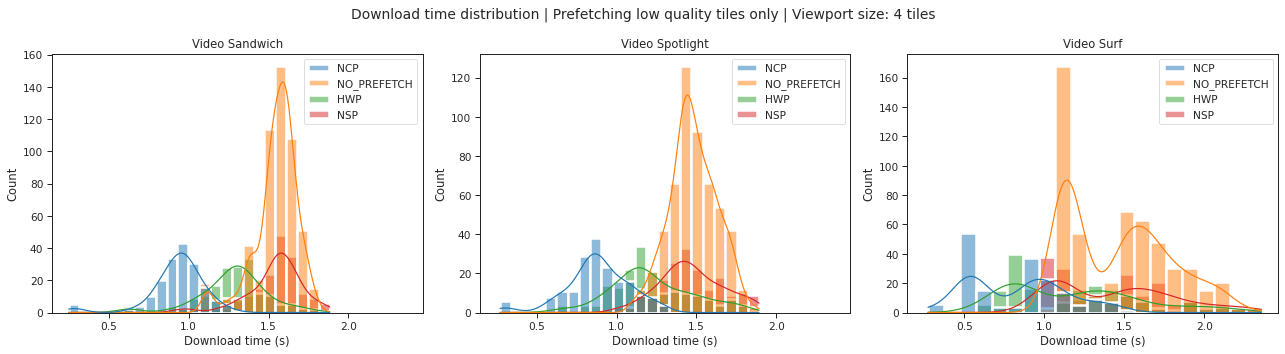

In [15]:
fig, axes = plt.subplots(1, len(v_unique), figsize=(18,5), sharex=True)

for i in range(len(v_unique)):
    axis = axes[i]
    sns.histplot(
        data=results_df[(results_df['video'] == v_unique[i])], 
        x="seg_resp_time", linewidth=2.5, hue="prefetch", kde=True, ax=axis)

    axis.set_title(f'Video {VIDEO_TITLES[i]}')
#         axis.set_title(f'Video {j*2}')
    axis.set_xlabel('Download time (s)')
    axis.get_legend().set_title("")
#     axis.set_xlim(0,2.5)
plt.suptitle(f'Download time distribution | {SETUPS[TYPE]} | Viewport size: {K} tiles')
plt.tight_layout()

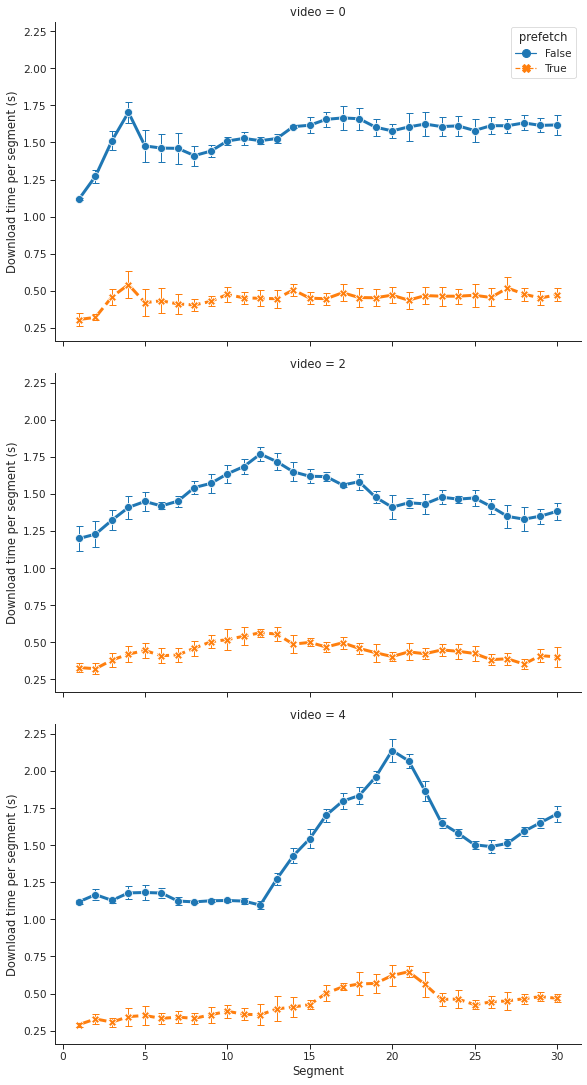

In [9]:
ax = sns.relplot(x="segment", 
                 y="seg_resp_time", 
                 hue="prefetch",
                 style='prefetch',
                 data=results_df, 
                 kind="line",
                 height=5, 
                 aspect=1.618,
                 row ="video",
                 err_style='bars', 
                 err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
                 ci='sd', 
                 markers=True,
                 linewidth=3,
                 facet_kws = {'legend_out': False}
                )
ax.set_axis_labels("Segment", "Download time per segment (s)")#.set(ylim=(0, .5))